# Estimate by modelization the evolution of Unemployment Rate in USA

## Import

In [1]:
import os
import sys
import re
import time
import math
from datetime import timedelta
from datetime import timezone
from datetime import datetime
import json

# Third Party
import pandas as pd
import numpy as np
import requests

# FINANCE
import yfinance as yf
import ccxt
from openbb_terminal.sdk import openbb

# CHARTS
import ta
from ta.trend import IchimokuIndicator
from ta.momentum import RSIIndicator
from ta.volatility import AverageTrueRange
from ta.volume import VolumeWeightedAveragePrice
# PLOT
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_theme(context='paper', style='whitegrid')

Portfolio Optimization Toolkit is disabled. To use the Optimization features please install the toolkit following the instructions here: https://my.openbb.co/app/sdk/installation

## Definitions

In [2]:

from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())
API_GLASSNODE_KEY = os.getenv("API_GLASSNODE_KEY")
openbb.keys.glassnode(key=os.getenv("API_GLASSNODE_KEY"))
openbb.keys.messari(key=os.getenv("API_MESSARI_KEY"))

# unemployment
path_unemployment = "data/UNRATE.csv"
# federal funds rate
path_rate = "data/FEDFUNDS.csv"
# inflation
path_inflation = "data/CPIAUCSL.csv"


## Load data

- unemployment data :  https://www.bls.gov/charts/employment-situation/civilian-unemployment-rate.htm# 
    - less data :  https://fred.stlouisfed.org/series/UNRATE
- Interest rate :  https://fred.stlouisfed.org/series/FEDFUNDS
- INFLATION : https://www.usinflationcalculator.com/inflation/current-inflation-rates/
   - calculated from CPI : https://fred.stlouisfed.org/series/CPIAUCSL  
   Inflation = 100 * [ CPI(month, year) - CPI(month, year-1) ] / CPI(month, year-1)
- SPX SP500 : Yahoo Finance Ticker ^GSPC


In [3]:
# load local data
# load unemployment
df_unemployment = pd.read_csv(path_unemployment)
df_unemployment["DATE"] = pd.to_datetime(df_unemployment["DATE"])
df_unemployment.rename(columns={"UNRATE": "Total"}, inplace=True)
# load federal funds rate
df_rate = pd.read_csv(path_rate)
df_rate["DATE"] = pd.to_datetime(df_rate["DATE"])
# load inflation
df_inflation = pd.read_csv(path_inflation)
df_inflation["DATE"] = pd.to_datetime(df_inflation["DATE"])

In [4]:

df_unemployment

,DATE,Total
0,1948-01-01,3.4
1,1948-02-01,3.8
2,1948-03-01,4.0
3,1948-04-01,3.9
4,1948-05-01,3.5
...,...,...
915,2024-04-01,3.9
916,2024-05-01,4.0
917,2024-06-01,4.1
918,2024-07-01,4.3


In [5]:
# check unemployment nan into df_unemployment 
# assert that nothing is nan
assert df_unemployment.isna().sum().sum() == 0

In [6]:
100 * (314.540 - 305.691) / 305.691

2.894753198491302

In [7]:
100*(190.9 - 185.0) / 185.0

3.189189189189192

In [8]:
# calculatate inflation
df_inflation["CPI-12"]= df_inflation["CPIAUCSL"].shift(12)
df_inflation["Inflation"] = 100 * (df_inflation["CPIAUCSL"] - df_inflation["CPI-12"]) / df_inflation["CPI-12"]
df_inflation.tail(20)

,DATE,CPIAUCSL,CPI-12,Inflation
911,2022-12-01,298.812,280.808,6.411498
912,2023-01-01,300.356,282.390,6.362123
913,2023-02-01,301.509,284.535,5.965523
914,2023-03-01,301.744,287.553,4.935090
915,2023-04-01,303.032,288.764,4.941059
916,2023-05-01,303.365,291.359,4.120690
917,2023-06-01,304.003,294.996,3.053262
918,2023-07-01,304.628,294.977,3.271781
919,2023-08-01,306.187,295.209,3.718721
920,2023-09-01,307.288,296.341,3.694055


In [9]:
df = df_unemployment.merge(df_inflation.filter(["DATE", "Inflation"]), on="DATE", how="left")

df.tail(12)

,DATE,Total,Inflation
908,2023-09-01,3.8,3.694055
909,2023-10-01,3.8,3.245787
910,2023-11-01,3.7,3.139482
911,2023-12-01,3.7,3.323160
912,2024-01-01,3.7,3.105981
913,2024-02-01,3.9,3.165743
914,2024-03-01,3.8,3.475131
915,2024-04-01,3.9,3.357731
916,2024-05-01,4.0,3.250210
917,2024-06-01,4.1,2.975629


In [10]:
df_rate

,DATE,FEDFUNDS
0,1954-07-01,0.80
1,1954-08-01,1.22
2,1954-09-01,1.07
3,1954-10-01,0.85
4,1954-11-01,0.83
...,...,...
837,2024-04-01,5.33
838,2024-05-01,5.33
839,2024-06-01,5.33
840,2024-07-01,5.33


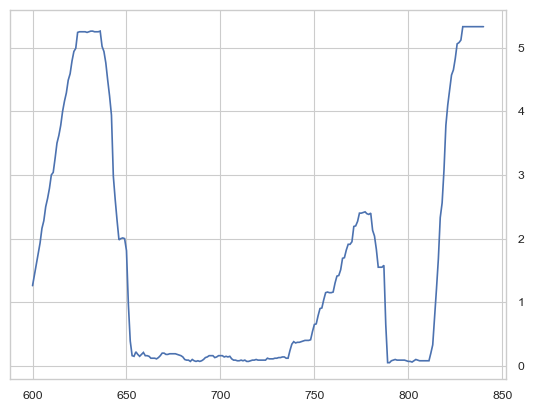

In [11]:
plt.plot(df_rate[(df_rate["DATE"] >= "2004-07-01") & (df_rate["DATE"] <= "2024-07-01")]["FEDFUNDS"])

In [12]:
# add funds rate to df
df = df.merge(df_rate, on="DATE", how="left")
#df["FEDFUNDS"] = df_rate[(df_rate["DATE"] >= "2004-07-01") & (df_rate["DATE"] <= "2024-07-01")]["FEDFUNDS"].values
df


,DATE,Total,Inflation,FEDFUNDS
0,1948-01-01,3.4,10.242086,NaN
1,1948-02-01,3.8,9.481961,NaN
2,1948-03-01,4.0,6.818182,NaN
3,1948-04-01,3.9,8.272727,NaN
4,1948-05-01,3.5,9.384966,NaN
...,...,...,...,...
915,2024-04-01,3.9,3.357731,5.33
916,2024-05-01,4.0,3.250210,5.33
917,2024-06-01,4.1,2.975629,5.33
918,2024-07-01,4.3,2.923566,5.33


In [13]:
#df.dropna(inplace=True)
df 

,DATE,Total,Inflation,FEDFUNDS
0,1948-01-01,3.4,10.242086,NaN
1,1948-02-01,3.8,9.481961,NaN
2,1948-03-01,4.0,6.818182,NaN
3,1948-04-01,3.9,8.272727,NaN
4,1948-05-01,3.5,9.384966,NaN
...,...,...,...,...
915,2024-04-01,3.9,3.357731,5.33
916,2024-05-01,4.0,3.250210,5.33
917,2024-06-01,4.1,2.975629,5.33
918,2024-07-01,4.3,2.923566,5.33


In [14]:
"""# check if nan into FEDFUNDS
assert df[df["FEDFUNDS"].isna()].shape[0] == 0
# find Nan value in inflation
assert  df[df["Inflation"].isna()].shape[0]==0"""

'# check if nan into FEDFUNDS\nassert df[df["FEDFUNDS"].isna()].shape[0] == 0\n# find Nan value in inflation\nassert  df[df["Inflation"].isna()].shape[0]==0'

In [15]:
# add do Df the indice SPX from yahoo finance ? 
# add the indice SPX from yahoo finance
date_start = df["DATE"].min().strftime("%Y-%m-%d")
date_end = df["DATE"].max().strftime("%Y-%m-%d")

updating = True
# check if data/SPX.csv exists and if last date is the last date of df
if os.path.exists("data/SPX.csv"):
    df_spx = pd.read_csv("data/SPX.csv")
    last_date = df_spx["DATE"].max()
    if last_date >= date_end:
        print("SPX data is up to date")
        updating = False
    else:
        print("SPX data is not up to date")
        updating = True
else:
    print("SPX data is not up to date")
    updating = True

if updating:
    print("Updating...")
    df_spx = yf.Ticker("^GSPC").history(
            start=date_start, interval="1mo")
    df_spx = df_spx[["Close"]]
    df_spx["DATE"] = df_spx.index
    df_spx["DATE"] = df_spx["DATE"].dt.strftime("%Y-%m-%d")
    df_spx["DATE"] = pd.to_datetime(df_spx["DATE"])
    df_spx.to_csv("data/SPX.csv", index=False)
    print("SPX data is updated")
else:
    df_spx["DATE"] = pd.to_datetime(df_spx["DATE"])
df_spx

SPX data is up to date


,Close,DATE
0,179.630005,1985-01-01
1,181.179993,1985-02-01
2,180.660004,1985-03-01
3,179.830002,1985-04-01
4,189.550003,1985-05-01
...,...,...
472,5277.509766,2024-05-01
473,5460.479980,2024-06-01
474,5522.299805,2024-07-01
475,5648.399902,2024-08-01


In [16]:
df_tmp = df_spx.copy()
df_tmp["Close-12"] = df_tmp["Close"].shift(12)
df_tmp["SPX_diff"] = (df_tmp["Close"] - df_tmp["Close-12"]) / df_tmp["Close-12"]
df_spx = df_tmp

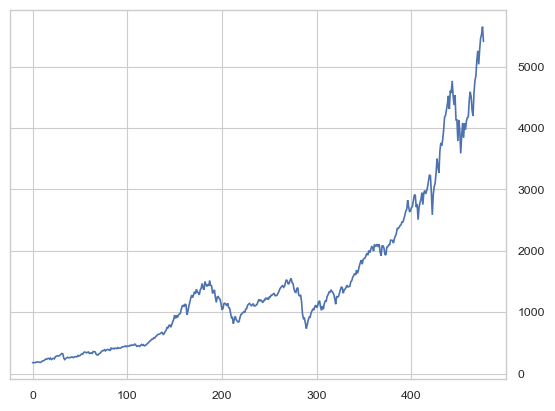

In [17]:
plt.plot(df_spx["Close"].values)

In [18]:
df = df.merge(df_spx.filter(["DATE","SPX_diff"]), how="left", on="DATE")
df

,DATE,Total,Inflation,FEDFUNDS,SPX_diff
0,1948-01-01,3.4,10.242086,NaN,NaN
1,1948-02-01,3.8,9.481961,NaN,NaN
2,1948-03-01,4.0,6.818182,NaN,NaN
3,1948-04-01,3.9,8.272727,NaN,NaN
4,1948-05-01,3.5,9.384966,NaN,NaN
...,...,...,...,...,...
915,2024-04-01,3.9,3.357731,5.33,0.207750
916,2024-05-01,4.0,3.250210,5.33,0.262613
917,2024-06-01,4.1,2.975629,5.33,0.226969
918,2024-07-01,4.3,2.923566,5.33,0.203388


In [19]:
#df.dropna(inplace=True)

In [20]:
df

,DATE,Total,Inflation,FEDFUNDS,SPX_diff
0,1948-01-01,3.4,10.242086,NaN,NaN
1,1948-02-01,3.8,9.481961,NaN,NaN
2,1948-03-01,4.0,6.818182,NaN,NaN
3,1948-04-01,3.9,8.272727,NaN,NaN
4,1948-05-01,3.5,9.384966,NaN,NaN
...,...,...,...,...,...
915,2024-04-01,3.9,3.357731,5.33,0.207750
916,2024-05-01,4.0,3.250210,5.33,0.262613
917,2024-06-01,4.1,2.975629,5.33,0.226969
918,2024-07-01,4.3,2.923566,5.33,0.203388


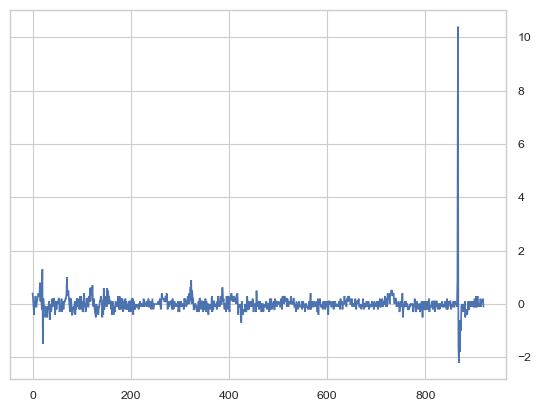

In [21]:



plt.plot(np.diff(df["Total"]))

In [22]:
# calculate next month diff in unemployment rate 
df["Total_diff"] = np.diff(df["Total"], append=np.nan)
df

,DATE,Total,Inflation,FEDFUNDS,SPX_diff,Total_diff
0,1948-01-01,3.4,10.242086,NaN,NaN,0.4
1,1948-02-01,3.8,9.481961,NaN,NaN,0.2
2,1948-03-01,4.0,6.818182,NaN,NaN,-0.1
3,1948-04-01,3.9,8.272727,NaN,NaN,-0.4
4,1948-05-01,3.5,9.384966,NaN,NaN,0.1
...,...,...,...,...,...,...
915,2024-04-01,3.9,3.357731,5.33,0.207750,0.1
916,2024-05-01,4.0,3.250210,5.33,0.262613,0.1
917,2024-06-01,4.1,2.975629,5.33,0.226969,0.2
918,2024-07-01,4.3,2.923566,5.33,0.203388,-0.1


In [23]:
ur_lower = df["Total_diff"] < 0
ur_higher = df["Total_diff"] > 0
ur_stable = df["Total_diff"] == 0
# add ur to df
df["ur_lower"] = ur_lower
df["ur_higher"] = ur_higher
df["ur_stable"] = ur_stable
df

,DATE,Total,Inflation,FEDFUNDS,SPX_diff,Total_diff,ur_lower,ur_higher,ur_stable
0,1948-01-01,3.4,10.242086,NaN,NaN,0.4,False,True,False
1,1948-02-01,3.8,9.481961,NaN,NaN,0.2,False,True,False
2,1948-03-01,4.0,6.818182,NaN,NaN,-0.1,True,False,False
3,1948-04-01,3.9,8.272727,NaN,NaN,-0.4,True,False,False
4,1948-05-01,3.5,9.384966,NaN,NaN,0.1,False,True,False
...,...,...,...,...,...,...,...,...,...
915,2024-04-01,3.9,3.357731,5.33,0.207750,0.1,False,True,False
916,2024-05-01,4.0,3.250210,5.33,0.262613,0.1,False,True,False
917,2024-06-01,4.1,2.975629,5.33,0.226969,0.2,False,True,False
918,2024-07-01,4.3,2.923566,5.33,0.203388,-0.1,True,False,False


In [24]:
# function to convert from each str input (i.e: "July 2003") to just the number of the month (i.e: 7) 
def clean_month(str_month):
    return str_month[0:3] + " " + str_month[-4:]
#clean_month("July 2003")
#df["Month"] = df["Month"].apply(clean_month)

In [25]:
# convert df["Month"] into a number of the month
#df["date"] = pd.to_datetime(df["Month"], format="%b %Y")

In [26]:
df

,DATE,Total,Inflation,FEDFUNDS,SPX_diff,Total_diff,ur_lower,ur_higher,ur_stable
0,1948-01-01,3.4,10.242086,NaN,NaN,0.4,False,True,False
1,1948-02-01,3.8,9.481961,NaN,NaN,0.2,False,True,False
2,1948-03-01,4.0,6.818182,NaN,NaN,-0.1,True,False,False
3,1948-04-01,3.9,8.272727,NaN,NaN,-0.4,True,False,False
4,1948-05-01,3.5,9.384966,NaN,NaN,0.1,False,True,False
...,...,...,...,...,...,...,...,...,...
915,2024-04-01,3.9,3.357731,5.33,0.207750,0.1,False,True,False
916,2024-05-01,4.0,3.250210,5.33,0.262613,0.1,False,True,False
917,2024-06-01,4.1,2.975629,5.33,0.226969,0.2,False,True,False
918,2024-07-01,4.3,2.923566,5.33,0.203388,-0.1,True,False,False


In [27]:
df["num_month"] = df["DATE"].dt.month

In [28]:
df

,DATE,Total,Inflation,FEDFUNDS,SPX_diff,Total_diff,ur_lower,ur_higher,ur_stable,num_month
0,1948-01-01,3.4,10.242086,NaN,NaN,0.4,False,True,False,1
1,1948-02-01,3.8,9.481961,NaN,NaN,0.2,False,True,False,2
2,1948-03-01,4.0,6.818182,NaN,NaN,-0.1,True,False,False,3
3,1948-04-01,3.9,8.272727,NaN,NaN,-0.4,True,False,False,4
4,1948-05-01,3.5,9.384966,NaN,NaN,0.1,False,True,False,5
...,...,...,...,...,...,...,...,...,...,...
915,2024-04-01,3.9,3.357731,5.33,0.207750,0.1,False,True,False,4
916,2024-05-01,4.0,3.250210,5.33,0.262613,0.1,False,True,False,5
917,2024-06-01,4.1,2.975629,5.33,0.226969,0.2,False,True,False,6
918,2024-07-01,4.3,2.923566,5.33,0.203388,-0.1,True,False,False,7


In [29]:
# add last 3 month data about unemployment rate, inflation , fedfunds, SPX to df 
# as new columns (i.e: "Total-1", "Total-2", "Total-3")

df["Total-1"] = df["Total"].shift(1)
df["Total-2"] = df["Total"].shift(2)
df["Total-3"] = df["Total"].shift(3)

df["Inflation-1"] = df["Inflation"].shift(1)
df["Inflation-2"] = df["Inflation"].shift(2)
df["Inflation-3"] = df["Inflation"].shift(3)

df["fedfunds-1"] = df["FEDFUNDS"].shift(1)
df["fedfunds-2"] = df["FEDFUNDS"].shift(2)
df["fedfunds-3"] = df["FEDFUNDS"].shift(3)

df["spx-1"] = df["SPX_diff"].shift(1)
df["spx-2"] = df["SPX_diff"].shift(2)
df["spx-3"] = df["SPX_diff"].shift(3)

"""# same for "Men, 20 years and over"
df["Men-1"] = df["Men, 20 years and over"].shift(1)
df["Men-2"] = df["Men, 20 years and over"].shift(2)
df["Men-3"] = df["Men, 20 years and over"].shift(3)

#same for "Women, 20 years and over"
df["Women-1"] = df["Women, 20 years and over"].shift(1)
df["Women-2"] = df["Women, 20 years and over"].shift(2)
df["Women-3"] = df["Women, 20 years and over"].shift(3)

# same for "16 to 19 years old"	
df["16-1"] = df["16 to 19 years old"].shift(1)
df["16-2"] = df["16 to 19 years old"].shift(2)
df["16-3"] = df["16 to 19 years old"].shift(3)

# same for 	"White"	
df["White-1"] = df["White"].shift(1)
df["White-2"] = df["White"].shift(2)
df["White-3"] = df["White"].shift(3)

# same for Black
df["Black-1"] = df["Black or African American"].shift(1)
df["Black-2"] = df["Black or African American"].shift(2)
df["Black-3"] = df["Black or African American"].shift(3)

# same for Asian
df["Asian-1"] = df["Asian"].shift(1)
df["Asian-2"] = df["Asian"].shift(2)
df["Asian-3"] = df["Asian"].shift(3)

# same for Hispanic or Latino
df["Hispanic-1"] = df["Hispanic or Latino"].shift(1)
df["Hispanic-2"] = df["Hispanic or Latino"].shift(2)
df["Hispanic-3"] = df["Hispanic or Latino"].shift(3)"""

'# same for "Men, 20 years and over"\ndf["Men-1"] = df["Men, 20 years and over"].shift(1)\ndf["Men-2"] = df["Men, 20 years and over"].shift(2)\ndf["Men-3"] = df["Men, 20 years and over"].shift(3)\n\n#same for "Women, 20 years and over"\ndf["Women-1"] = df["Women, 20 years and over"].shift(1)\ndf["Women-2"] = df["Women, 20 years and over"].shift(2)\ndf["Women-3"] = df["Women, 20 years and over"].shift(3)\n\n# same for "16 to 19 years old"\t\ndf["16-1"] = df["16 to 19 years old"].shift(1)\ndf["16-2"] = df["16 to 19 years old"].shift(2)\ndf["16-3"] = df["16 to 19 years old"].shift(3)\n\n# same for \t"White"\t\ndf["White-1"] = df["White"].shift(1)\ndf["White-2"] = df["White"].shift(2)\ndf["White-3"] = df["White"].shift(3)\n\n# same for Black\ndf["Black-1"] = df["Black or African American"].shift(1)\ndf["Black-2"] = df["Black or African American"].shift(2)\ndf["Black-3"] = df["Black or African American"].shift(3)\n\n# same for Asian\ndf["Asian-1"] = df["Asian"].shift(1)\ndf["Asian-2"] = df[

In [30]:
df.dropna(inplace=True)
df

,DATE,Total,Inflation,FEDFUNDS,SPX_diff,Total_diff,ur_lower,ur_higher,ur_stable,num_month,...,Total-3,Inflation-1,Inflation-2,Inflation-3,fedfunds-1,fedfunds-2,fedfunds-3,spx-1,spx-2,spx-3
459,1986-04-01,7.1,1.588785,6.99,0.309681,0.1,False,True,False,4,...,6.7,2.153558,3.198495,3.973510,7.48,7.86,8.14,0.322373,0.252456,0.178979
460,1986-05-01,7.2,1.679104,6.85,0.304933,0.0,False,False,True,5,...,7.2,1.588785,2.153558,3.198495,6.99,7.48,7.86,0.309681,0.322373,0.252456
461,1986-06-01,7.2,1.767442,6.92,0.307480,-0.2,True,False,False,6,...,7.2,1.679104,1.588785,2.153558,6.85,6.99,7.48,0.304933,0.309681,0.322373
462,1986-07-01,7.0,1.671309,6.56,0.236748,-0.1,True,False,False,7,...,7.1,1.767442,1.679104,1.588785,6.92,6.85,6.99,0.307480,0.304933,0.309681
463,1986-08-01,6.9,1.575533,6.17,0.340879,0.1,False,True,False,8,...,7.2,1.671309,1.767442,1.679104,6.56,6.92,6.85,0.236748,0.307480,0.304933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
914,2024-03-01,3.8,3.475131,5.33,0.278645,0.1,False,True,False,3,...,3.7,3.165743,3.105981,3.323160,5.33,5.33,5.33,0.283647,0.188650,0.242305
915,2024-04-01,3.9,3.357731,5.33,0.207750,0.1,False,True,False,4,...,3.7,3.475131,3.165743,3.105981,5.33,5.33,5.33,0.278645,0.283647,0.188650
916,2024-05-01,4.0,3.250210,5.33,0.262613,0.1,False,True,False,5,...,3.9,3.357731,3.475131,3.165743,5.33,5.33,5.33,0.207750,0.278645,0.283647
917,2024-06-01,4.1,2.975629,5.33,0.226969,0.2,False,True,False,6,...,3.8,3.250210,3.357731,3.475131,5.33,5.33,5.33,0.262613,0.207750,0.278645


In [31]:
df.columns

Index(['DATE', 'Total', 'Inflation', 'FEDFUNDS', 'SPX_diff', 'Total_diff',
       'ur_lower', 'ur_higher', 'ur_stable', 'num_month', 'Total-1', 'Total-2',
       'Total-3', 'Inflation-1', 'Inflation-2', 'Inflation-3', 'fedfunds-1',
       'fedfunds-2', 'fedfunds-3', 'spx-1', 'spx-2', 'spx-3'],
      dtype='object')

In [32]:
list_feat = ['Total', 'Inflation', 'FEDFUNDS', 'SPX_diff', 'num_month', 'Total-1',
       'Total-2', 'Total-3', 'Inflation-1', 'Inflation-2', 'Inflation-3',
       'fedfunds-1', 'fedfunds-2', 'fedfunds-3', 'spx-1', 'spx-2', 'spx-3']

df_x = df.filter(list_feat)
df_x

,Total,Inflation,FEDFUNDS,SPX_diff,num_month,Total-1,Total-2,Total-3,Inflation-1,Inflation-2,Inflation-3,fedfunds-1,fedfunds-2,fedfunds-3,spx-1,spx-2,spx-3
459,7.1,1.588785,6.99,0.309681,4,7.2,7.2,6.7,2.153558,3.198495,3.973510,7.48,7.86,8.14,0.322373,0.252456,0.178979
460,7.2,1.679104,6.85,0.304933,5,7.1,7.2,7.2,1.588785,2.153558,3.198495,6.99,7.48,7.86,0.309681,0.322373,0.252456
461,7.2,1.767442,6.92,0.307480,6,7.2,7.1,7.2,1.679104,1.588785,2.153558,6.85,6.99,7.48,0.304933,0.309681,0.322373
462,7.0,1.671309,6.56,0.236748,7,7.2,7.2,7.1,1.767442,1.679104,1.588785,6.92,6.85,6.99,0.307480,0.304933,0.309681
463,6.9,1.575533,6.17,0.340879,8,7.0,7.2,7.2,1.671309,1.767442,1.679104,6.56,6.92,6.85,0.236748,0.307480,0.304933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
914,3.8,3.475131,5.33,0.278645,3,3.9,3.7,3.7,3.165743,3.105981,3.323160,5.33,5.33,5.33,0.283647,0.188650,0.242305
915,3.9,3.357731,5.33,0.207750,4,3.8,3.9,3.7,3.475131,3.165743,3.105981,5.33,5.33,5.33,0.278645,0.283647,0.188650
916,4.0,3.250210,5.33,0.262613,5,3.9,3.8,3.9,3.357731,3.475131,3.165743,5.33,5.33,5.33,0.207750,0.278645,0.283647
917,4.1,2.975629,5.33,0.226969,6,4.0,3.9,3.8,3.250210,3.357731,3.475131,5.33,5.33,5.33,0.262613,0.207750,0.278645


In [33]:
df_y = df.filter(['Total_diff',
       'ur_lower', 'ur_higher', 'ur_stable'])
df_y

,Total_diff,ur_lower,ur_higher,ur_stable
459,0.1,False,True,False
460,0.0,False,False,True
461,-0.2,True,False,False
462,-0.1,True,False,False
463,0.1,False,True,False
...,...,...,...,...
914,0.1,False,True,False
915,0.1,False,True,False
916,0.1,False,True,False
917,0.2,False,True,False


In [34]:
data = df_x.values
data

array([[7.1       , 1.58878505, 6.99      , ..., 0.32237346, 0.25245616,
        0.17897897],
       [7.2       , 1.67910448, 6.85      , ..., 0.30968138, 0.32237346,
        0.25245616],
       [7.2       , 1.76744186, 6.92      , ..., 0.30493275, 0.30968138,
        0.32237346],
       ...,
       [4.        , 3.25021014, 5.33      , ..., 0.20775012, 0.27864533,
        0.28364675],
       [4.1       , 2.97562853, 5.33      , ..., 0.26261347, 0.20775012,
        0.27864533],
       [4.3       , 2.92356579, 5.33      , ..., 0.22696941, 0.26261347,
        0.20775012]])

## Target

In [35]:
list_targets = ["ur_lower", "ur_stable", "ur_higher"]

In [36]:
target = df_y["ur_lower"].values
target

array([False, False,  True,  True, False, False,  True,  True, False,
       False, False,  True, False,  True,  True,  True,  True, False,
        True,  True, False, False, False,  True, False,  True, False,
       False,  True, False,  True, False, False,  True,  True, False,
       False, False,  True, False, False, False, False, False, False,
        True,  True, False, False,  True, False, False, False, False,
       False, False, False, False, False,  True, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False,  True,  True, False,  True, False, False,  True,
        True,  True, False, False,  True,  True,  True,  True, False,
        True,  True, False, False,  True,  True,  True, False, False,
        True,  True,  True,  True,  True, False,  True, False, False,
        True, False, False, False,  True,  True, False, False, False,
        True, False, False, False,  True, False,  True, False, False,
       False, False,

## SPlit Train / Test

In [37]:
data.shape

(460, 17)

In [38]:
ratio_test = 0.05
nb_test = int(data.shape[0] * (1 - ratio_test))
print("nb_test : ", nb_test)
#from sklearn.model_selection import train_test_split
#xtrain, xtest, ytrain, ytest = train_test_split(data, target, train_size=0.8)
xtrain = data[:nb_test, :]
xtest = data[nb_test:, :]
ytrain = target[:nb_test]
ytest = target[nb_test:]

nb_test :  437


In [39]:
ytrain.shape

(437,)

In [40]:
ytest.shape

(23,)

In [41]:
df_train = df.iloc[:nb_test].copy()
df_train
df_test = df.iloc[nb_test:].copy()
df_test

,DATE,Total,Inflation,FEDFUNDS,SPX_diff,Total_diff,ur_lower,ur_higher,ur_stable,num_month,...,Total-3,Inflation-1,Inflation-2,Inflation-3,fedfunds-1,fedfunds-2,fedfunds-3,spx-1,spx-2,spx-3
896,2022-09-01,3.5,8.198272,2.56,-0.167594,0.1,False,True,False,9,...,3.6,8.218806,8.449819,8.989744,2.33,1.68,1.21,-0.125519,-0.060285,-0.119167
897,2022-10-01,3.6,7.751941,3.08,-0.159249,0.0,False,False,True,10,...,3.5,8.198272,8.218806,8.449819,2.56,2.33,1.68,-0.167594,-0.125519,-0.060285
898,2022-11-01,3.6,7.119466,3.78,-0.106610,-0.1,True,False,False,11,...,3.6,7.751941,8.198272,8.218806,3.08,2.56,2.33,-0.159249,-0.167594,-0.125519
899,2022-12-01,3.5,6.411498,4.10,-0.194428,-0.1,True,False,False,12,...,3.5,7.119466,7.751941,8.198272,3.78,3.08,2.56,-0.106610,-0.159249,-0.167594
900,2023-01-01,3.4,6.362123,4.33,-0.097208,0.2,False,True,False,1,...,3.6,6.411498,7.119466,7.751941,4.10,3.78,3.08,-0.194428,-0.106610,-0.159249
901,2023-02-01,3.6,5.965523,4.57,-0.092317,-0.1,True,False,False,2,...,3.6,6.362123,6.411498,7.119466,4.33,4.10,3.78,-0.097208,-0.194428,-0.106610
902,2023-03-01,3.5,4.935090,4.65,-0.092950,-0.1,True,False,False,3,...,3.5,5.965523,6.362123,6.411498,4.57,4.33,4.10,-0.092317,-0.097208,-0.194428
903,2023-04-01,3.4,4.941059,4.83,0.009088,0.3,False,True,False,4,...,3.4,4.935090,5.965523,6.362123,4.65,4.57,4.33,-0.092950,-0.092317,-0.097208
904,2023-05-01,3.7,4.120690,5.06,0.011539,-0.1,True,False,False,5,...,3.6,4.941059,4.935090,5.965523,4.83,4.65,4.57,0.009088,-0.092950,-0.092317
905,2023-06-01,3.6,3.053262,5.08,0.175676,-0.1,True,False,False,6,...,3.5,4.120690,4.941059,4.935090,5.06,4.83,4.65,0.011539,0.009088,-0.092950


### Check features repart

In [42]:
df_train["TRAIN"] = 1
df_test["TRAIN"] = 0
df = pd.concat([df_train, df_test], axis=0)
df

,DATE,Total,Inflation,FEDFUNDS,SPX_diff,Total_diff,ur_lower,ur_higher,ur_stable,num_month,...,Inflation-1,Inflation-2,Inflation-3,fedfunds-1,fedfunds-2,fedfunds-3,spx-1,spx-2,spx-3,TRAIN
459,1986-04-01,7.1,1.588785,6.99,0.309681,0.1,False,True,False,4,...,2.153558,3.198495,3.973510,7.48,7.86,8.14,0.322373,0.252456,0.178979,1
460,1986-05-01,7.2,1.679104,6.85,0.304933,0.0,False,False,True,5,...,1.588785,2.153558,3.198495,6.99,7.48,7.86,0.309681,0.322373,0.252456,1
461,1986-06-01,7.2,1.767442,6.92,0.307480,-0.2,True,False,False,6,...,1.679104,1.588785,2.153558,6.85,6.99,7.48,0.304933,0.309681,0.322373,1
462,1986-07-01,7.0,1.671309,6.56,0.236748,-0.1,True,False,False,7,...,1.767442,1.679104,1.588785,6.92,6.85,6.99,0.307480,0.304933,0.309681,1
463,1986-08-01,6.9,1.575533,6.17,0.340879,0.1,False,True,False,8,...,1.671309,1.767442,1.679104,6.56,6.92,6.85,0.236748,0.307480,0.304933,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
914,2024-03-01,3.8,3.475131,5.33,0.278645,0.1,False,True,False,3,...,3.165743,3.105981,3.323160,5.33,5.33,5.33,0.283647,0.188650,0.242305,0
915,2024-04-01,3.9,3.357731,5.33,0.207750,0.1,False,True,False,4,...,3.475131,3.165743,3.105981,5.33,5.33,5.33,0.278645,0.283647,0.188650,0
916,2024-05-01,4.0,3.250210,5.33,0.262613,0.1,False,True,False,5,...,3.357731,3.475131,3.165743,5.33,5.33,5.33,0.207750,0.278645,0.283647,0
917,2024-06-01,4.1,2.975629,5.33,0.226969,0.2,False,True,False,6,...,3.250210,3.357731,3.475131,5.33,5.33,5.33,0.262613,0.207750,0.278645,0


#### Check Out of range
check if Test out of Train range for each features

In [43]:
df_min = df.filter(list_feat).groupby(df["TRAIN"]).min().transpose()
df_min["feat"] = df_min.index
df_min["out_min"] = df_min[0] < df_min[1]
df_min["pc_out_min"] = df_min["feat"].apply(
    lambda x: 100*sum(df[df["TRAIN"] == 0 ][x] <  df[df["TRAIN"] == 1][x].min()) / df[df["TRAIN"] == 0 ].shape[0]
    )
df_min

TRAIN,0,1,feat,out_min,pc_out_min
Total,3.400000,3.500000,Total,True,8.695652
Inflation,2.923566,-1.958761,Inflation,False,0.000000
FEDFUNDS,2.560000,0.050000,FEDFUNDS,False,0.000000
SPX_diff,-0.194428,-0.447562,SPX_diff,False,0.000000
num_month,1.000000,1.000000,num_month,False,0.000000
Total-1,3.400000,3.500000,Total-1,True,8.695652
Total-2,3.400000,3.500000,Total-2,True,8.695652
Total-3,3.400000,3.500000,Total-3,True,8.695652
Inflation-1,2.975629,-1.958761,Inflation-1,False,0.000000
Inflation-2,3.053262,-1.958761,Inflation-2,False,0.000000


In [44]:
df_max = df.filter(list_feat).groupby(df["TRAIN"]).max().transpose()
df_max["feat"] = df_max.index
df_max["out_max"] = df_max[0] > df_max[1]
df_max["pc_out_max"] = df_max["feat"].apply(
    lambda x: 100*sum(df[df["TRAIN"] == 0 ][x] >  df[df["TRAIN"] == 1][x].max()) / df[df["TRAIN"] == 0 ].shape[0]
    )
df_max

TRAIN,0,1,feat,out_max,pc_out_max
Total,4.300000,14.800000,Total,False,0.000000
Inflation,8.198272,8.989744,Inflation,False,0.000000
FEDFUNDS,5.330000,9.850000,FEDFUNDS,False,0.000000
SPX_diff,0.283647,0.537145,SPX_diff,False,0.000000
num_month,12.000000,12.000000,num_month,False,0.000000
Total-1,4.100000,14.800000,Total-1,False,0.000000
Total-2,4.000000,14.800000,Total-2,False,0.000000
Total-3,3.900000,14.800000,Total-3,False,0.000000
Inflation-1,8.218806,8.989744,Inflation-1,False,0.000000
Inflation-2,8.449819,8.989744,Inflation-2,False,0.000000


In [45]:
df_min.at["Total", 1]

3.5

<Axes: ylabel='Total'>

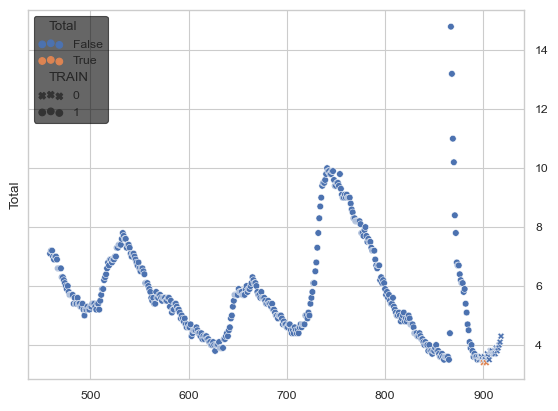

In [46]:
# detect unemployment rate < in test set
markers = {0: "X", 1: "o"}
sns.scatterplot(df.index.values, 
                df["Total"], hue=df["Total"] < df_min.at["Total", 1] , 
                style=df["TRAIN"], 
                markers=markers)

[Text(0.0, 1.0, 'Detect Inflation test > max TRAIN set')]

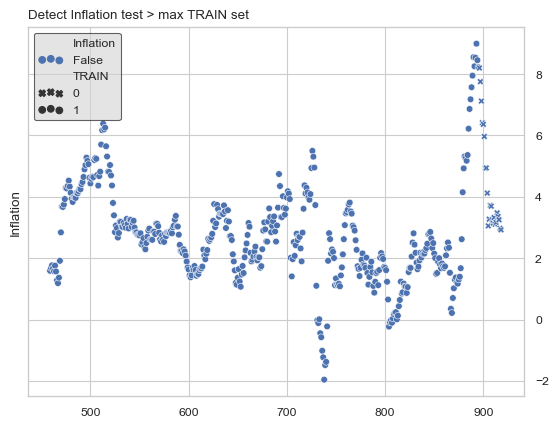

In [47]:
# detect FEDFUNDS > in test set

markers = {0: "X", 1: "o"}
ax = sns.scatterplot(df.index.values, 
                df["Inflation"], 
                hue=df["Inflation"] > df_max.at["Inflation", 1], 
                style=df["TRAIN"], 
                markers=markers)
sns.move_legend(ax, "best", facecolor="lightgrey")
ax.set(title="Detect Inflation test > max TRAIN set")

[Text(0.0, 1.0, 'Detect FEDFUNDS test > max TRAIN set')]

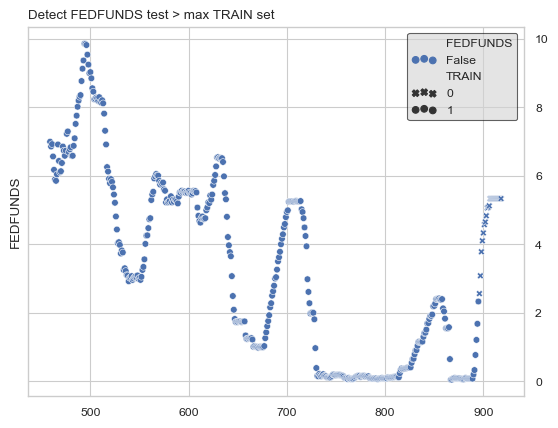

In [48]:
# detect FEDFUNDS > in test set

markers = {0: "X", 1: "o"}
ax = sns.scatterplot(df.index.values, 
                df["FEDFUNDS"], 
                hue=df["FEDFUNDS"] > df_max.at["FEDFUNDS", 1], 
                style=df["TRAIN"], 
                markers=markers,
                )
sns.move_legend(ax, "best", facecolor="lightgrey")
ax.set(title="Detect FEDFUNDS test > max TRAIN set")

### Check repart target

In [49]:
def print_repart(df_train, df_test, str_target):
    print("\nRepart for ", str_target, ":")
    print("- on TRAIN :\n",
        "  - proba:\n",
        df_train[str_target].value_counts() / df_train.shape[0],
        "\n  - nb: ", 
        df_train[str_target].shape[0]*(df_train[str_target].value_counts() / df_train.shape[0]).values,
    )
    print("- on TEST :\n", 
        "  - proba:\n",
        df_test[str_target].value_counts() / df_test.shape[0],
        "\n  - nb: ", 
        df_test[str_target].shape[0]*(df_test[str_target].value_counts() / df_test.shape[0]).values,)

for str_target in list_targets:
    print_repart(df_train, df_test, str_target)

print("end")


Repart for  ur_lower :
- on TRAIN :
   - proba:
 False    0.574371
True     0.425629
Name: ur_lower, dtype: float64 
  - nb:  [251. 186.]
- on TEST :
   - proba:
 False    0.608696
True     0.391304
Name: ur_lower, dtype: float64 
  - nb:  [14.  9.]

Repart for  ur_stable :
- on TRAIN :
   - proba:
 False    0.729977
True     0.270023
Name: ur_stable, dtype: float64 
  - nb:  [319. 118.]
- on TEST :
   - proba:
 False    0.782609
True     0.217391
Name: ur_stable, dtype: float64 
  - nb:  [18.  5.]

Repart for  ur_higher :
- on TRAIN :
   - proba:
 False    0.695652
True     0.304348
Name: ur_higher, dtype: float64 
  - nb:  [304. 133.]
- on TEST :
   - proba:
 False    0.608696
True     0.391304
Name: ur_higher, dtype: float64 
  - nb:  [14.  9.]
end


## Scale

In [50]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X = scaler.fit_transform(xtrain)
X_test = scaler.transform(xtest)

# for last pred : (to predict next month value)
x_for_pred = df.filter(list_feat).iloc[-1].values.reshape(1, -1)
X_for_pred = scaler.transform(x_for_pred)
X_for_pred

array([[-0.94402194,  0.13711415,  0.78517905,  0.64503223,  0.14718341,
        -1.07174116, -1.13942853, -1.20684368,  0.1817087 ,  0.37291771,
         0.45984413,  0.77872609,  0.77125212,  0.76310848,  0.78682763,
         1.00645465,  0.65869568]])

In [51]:
#scaler_y = StandardScaler()

#Y = scaler_y.fit_transform(ytrain.reshape(-1, 1))
Y = ytrain.reshape(-1, 1)
Y_test = ytest.reshape(-1, 1)

## Train

### Test some models

In [52]:
from sklearn.base import clone
def choose_target(df_y, target, nb_test):
    print("\nTarget : ", target)
    arr_target = df_y[target].values
    ytrain = arr_target[:nb_test]
    ytest = arr_target[nb_test:]
    Y = ytrain.reshape(-1, 1)
    Y_test = ytest.reshape(-1, 1)
    return Y, Y_test


def fit_clf(clf, X, Y, X_test, Y_test, X_for_pred):
    clf.fit(X, Y)
    print("TRAIN score :", clf.score(X, Y))
    print("TEST score :", clf.score(X_test, Y_test))
    print("Next month : ", 
      clf.predict(X_for_pred),
      np.max(clf.predict_proba(X_for_pred)[0]),
    )
    return clf
    
def multi_target_fit(clf, df_y, nb_test, list_targets):
    list_clf = []
    for target in list_targets:
        Y, Y_test = choose_target(df_y, target=target, nb_test=nb_test)
        new_clf = fit_clf(clone(clf), X, Y, X_test, Y_test, X_for_pred)
        list_clf.append(new_clf)
    return list_clf

In [53]:
from sklearn.naive_bayes import BernoulliNB
clf = BernoulliNB()
list_clf = multi_target_fit(clf, df_y, nb_test, list_targets)


Target :  ur_lower
TRAIN score : 0.5789473684210527
TEST score : 0.6086956521739131
Next month :  [False] 0.8587945423612996

Target :  ur_stable
TRAIN score : 0.7093821510297483
TEST score : 0.5652173913043478
Next month :  [ True] 0.5065497722292504

Target :  ur_higher
TRAIN score : 0.6590389016018307
TEST score : 0.34782608695652173
Next month :  [False] 0.5491756906625094


In [55]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
list_clf = multi_target_fit(clf, df_y, nb_test, list_targets)

"""clf.fit(X, Y)
print("TRAIN score :", clf.score(X, Y))
print("TEST score :", clf.score(X_test, Y_test))
print("Next month : ", clf.predict(X_for_pred))
print("classes : ", clf.classes_)
print("classes prob : ", clf.predict_proba(X_for_pred))"""


Target :  ur_lower
TRAIN score : 0.5812356979405034
TEST score : 0.5652173913043478
Next month :  [False] 0.5384244879806037

Target :  ur_stable
TRAIN score : 0.5926773455377574
TEST score : 0.6086956521739131
Next month :  [ True] 0.6369521082419418

Target :  ur_higher
TRAIN score : 0.6956521739130435
TEST score : 0.43478260869565216
Next month :  [False] 0.8968526828302139


'clf.fit(X, Y)\nprint("TRAIN score :", clf.score(X, Y))\nprint("TEST score :", clf.score(X_test, Y_test))\nprint("Next month : ", clf.predict(X_for_pred))\nprint("classes : ", clf.classes_)\nprint("classes prob : ", clf.predict_proba(X_for_pred))'

In [59]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)
list_clf = multi_target_fit(clf, df_y, nb_test, list_targets)


Target :  ur_lower
TRAIN score : 1.0
TEST score : 0.5217391304347826
Next month :  [False] 1.0

Target :  ur_stable
TRAIN score : 1.0
TEST score : 0.782608695652174
Next month :  [False] 1.0

Target :  ur_higher
TRAIN score : 1.0
TEST score : 0.4782608695652174
Next month :  [False] 1.0


In [60]:
from sklearn.svm import SVC
clf = SVC(gamma='auto', probability=True)
list_clf = multi_target_fit(clf, df_y, nb_test, list_targets)


Target :  ur_lower
TRAIN score : 0.6521739130434783
TEST score : 0.5217391304347826
Next month :  [False] 0.6126312516976923

Target :  ur_stable
TRAIN score : 0.7299771167048055
TEST score : 0.782608695652174
Next month :  [False] 0.7714126755274415

Target :  ur_higher
TRAIN score : 0.7574370709382151
TEST score : 0.5652173913043478
Next month :  [False] 0.7628591117331435


In [62]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(random_state=0, loss="log_loss")
list_clf = multi_target_fit(clf, df_y, nb_test, list_targets)


Target :  ur_lower
TRAIN score : 0.5263157894736842
TEST score : 0.30434782608695654
Next month :  [ True] 0.9916956439748819

Target :  ur_stable
TRAIN score : 0.6292906178489702
TEST score : 0.6521739130434783
Next month :  [ True] 0.6894716666012086

Target :  ur_higher
TRAIN score : 0.7025171624713958
TEST score : 0.6086956521739131
Next month :  [False] 0.9726158799575633


In [67]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(random_state=0)
list_clf = multi_target_fit(clf, df_y, nb_test, list_targets)


Target :  ur_lower
TRAIN score : 0.9679633867276888
TEST score : 0.6956521739130435
Next month :  [ True] 0.5897742585321016

Target :  ur_stable
TRAIN score : 0.954233409610984
TEST score : 0.782608695652174
Next month :  [False] 0.8737103136512954

Target :  ur_higher
TRAIN score : 0.9382151029748284
TEST score : 0.6086956521739131
Next month :  [False] 0.8692885010792621


In [68]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=3)
list_clf = multi_target_fit(clf, df_y, nb_test, list_targets)


Target :  ur_lower
TRAIN score : 0.7322654462242563
TEST score : 0.6086956521739131
Next month :  [False] 0.6666666666666666

Target :  ur_stable
TRAIN score : 0.8009153318077803
TEST score : 0.8260869565217391
Next month :  [False] 1.0

Target :  ur_higher
TRAIN score : 0.7665903890160183
TEST score : 0.6521739130434783
Next month :  [ True] 0.6666666666666666


In [72]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(random_state=0, 
                    max_iter=10000,
                    early_stopping=True,
                    n_iter_no_change=1000)
list_clf = multi_target_fit(clf, df_y, nb_test, list_targets)


Target :  ur_lower
TRAIN score : 0.8672768878718535
TEST score : 0.5217391304347826
Next month :  [ True] 0.572460655725146

Target :  ur_stable
TRAIN score : 0.7734553775743707
TEST score : 0.8695652173913043
Next month :  [False] 0.7214984168135683

Target :  ur_higher
TRAIN score : 0.700228832951945
TEST score : 0.4782608695652174
Next month :  [False] 0.7496680842185146



Target :  ur_higher
TRAIN score : 0.700228832951945
TEST score : 0.4782608695652174
Next month :  [False]
classes :  [False  True]
classes prob :  [[0.74966808 0.25033192]]


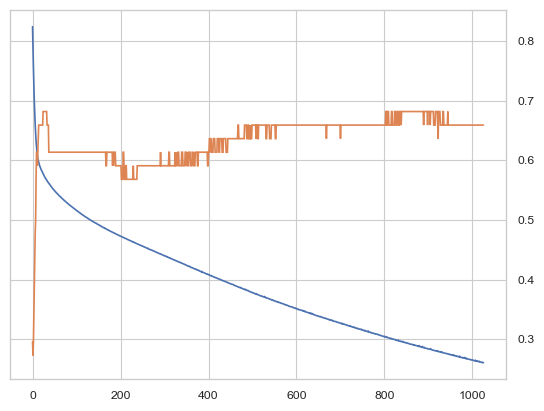

In [73]:
from sklearn.neural_network import MLPClassifier
Y, Y_test = choose_target(df_y, target="ur_higher", nb_test=nb_test)
clf = MLPClassifier(random_state=0, 
                    max_iter=10000,
                    early_stopping=True,
                    n_iter_no_change=1000)
clf.fit(X, Y)
print("TRAIN score :", clf.score(X, Y))
print("TEST score :", clf.score(X_test, Y_test))
print("Next month : ", clf.predict(X_for_pred))
print("classes : ", clf.classes_)
print("classes prob : ", clf.predict_proba(X_for_pred))
plt.plot(clf.loss_curve_)
plt.plot(clf.validation_scores_)

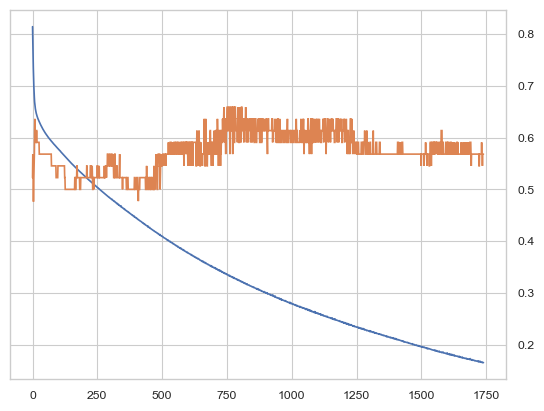

In [61]:
clf.predict(X_for_pred)

array([ True])

In [62]:
clf.classes_

array([False,  True])

In [63]:
clf.predict_proba(X_for_pred)

array([[0.42753934, 0.57246066]])

### KNN

In [64]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=3)

# target lower
print("TARGET : LOWER ")
target = df_y["ur_lower"].values
ytrain = target[:nb_test]
ytest = target[nb_test:]
Y = ytrain.reshape(-1, 1)
Y_test = ytest.reshape(-1, 1)
clf.fit(X, Y)
print("TRAIN score :", clf.score(X, Y))
print("TEST score :", clf.score(X_test, Y_test))
print("Next month : ", clf.predict(X_for_pred))
print("classes : ", clf.classes_)
print("classes prob : ", clf.predict_proba(X_for_pred))

# target higher
print("TARGET : HIGHER")
target = df_y["ur_higher"].values
ytrain = target[:nb_test]
ytest = target[nb_test:]
Y = ytrain.reshape(-1, 1)
Y_test = ytest.reshape(-1, 1)
clf.fit(X, Y)
print("TRAIN score :", clf.score(X, Y))
print("TEST score :", clf.score(X_test, Y_test))
print("Next month : ", clf.predict(X_for_pred))
print("classes : ", clf.classes_)
print("classes prob : ", clf.predict_proba(X_for_pred))

# target stable
print("\nTARGET : STABLE")
target = df_y["ur_stable"].values
ytrain = target[:nb_test]
ytest = target[nb_test:]
Y = ytrain.reshape(-1, 1)
Y_test = ytest.reshape(-1, 1)
clf.fit(X, Y)
print("TRAIN score :", clf.score(X, Y))
print("TEST score :", clf.score(X_test, Y_test))
print("Next month : ", clf.predict(X_for_pred))
print("classes : ", clf.classes_)
print("classes prob : ", clf.predict_proba(X_for_pred))

TARGET : LOWER 
TRAIN score : 0.7322654462242563
TEST score : 0.6086956521739131
Next month :  [False]
classes :  [False  True]
classes prob :  [[0.66666667 0.33333333]]
TARGET : HIGHER
TRAIN score : 0.7665903890160183
TEST score : 0.6521739130434783
Next month :  [ True]
classes :  [False  True]
classes prob :  [[0.33333333 0.66666667]]

TARGET : STABLE
TRAIN score : 0.8009153318077803
TEST score : 0.8260869565217391
Next month :  [False]
classes :  [False  True]
classes prob :  [[1. 0.]]


### MCP

In [65]:
from sklearn.neural_network  import MLPClassifier
list_pred = []
list_prob = []

TARGET : LOWER 
TRAIN score : 0.5697940503432495
TEST score : 0.6086956521739131
Next month :  [False]
classes :  [False  True]
classes prob :  [[0.59725586 0.40274414]]
nb_test:  9


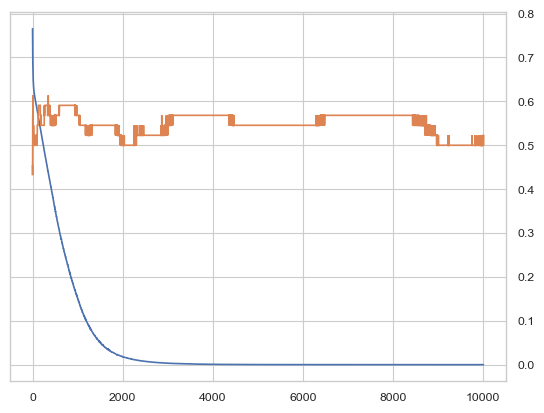

In [66]:
# target lower
print("TARGET : LOWER ")
target = df_y["ur_lower"].values
ytrain = target[:nb_test]
ytest = target[nb_test:]
Y = ytrain.reshape(-1, 1)
Y_test = ytest.reshape(-1, 1)

clf = MLPClassifier(random_state=0,
                    hidden_layer_sizes=(32,16),
                    max_iter=50000,
                    early_stopping=True,
                    n_iter_no_change=10000)
clf.fit(X, Y)
print("TRAIN score :", clf.score(X, Y))
print("TEST score :", clf.score(X_test, Y_test))
print("Next month : ", clf.predict(X_for_pred))
print("classes : ", clf.classes_)
print("classes prob : ", clf.predict_proba(X_for_pred))
nb_best = np.argmax(clf.validation_scores_ == clf.best_validation_score_)
print("nb_test: ", nb_best)
plt.plot(clf.loss_curve_)
plt.plot(clf.validation_scores_)

In [67]:
pred = clf.predict(X_for_pred)[0]
arr_prob = clf.predict_proba(X_for_pred)
if pred: 
    prob = arr_prob[0][1]
else:
    prob = arr_prob[0][0]

list_pred.append(pred)
list_prob.append(prob)
print(list_pred, list_prob)

[False] [0.5972558640980496]


TARGET : STABLE 
TRAIN score : 0.5697940503432495
TEST score : 0.782608695652174
Next month :  [False]
classes :  [False  True]
classes prob :  [[0.54610613 0.45389387]]
nb_test:  8


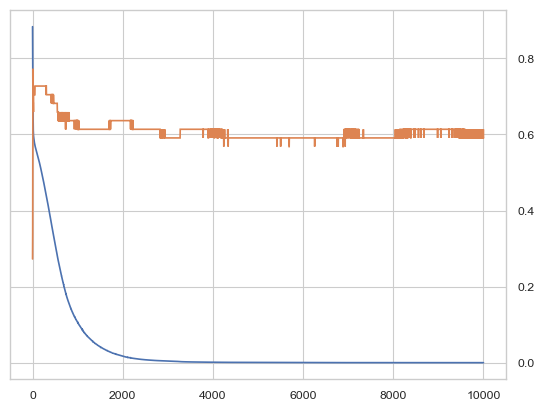

In [68]:
# target stable
print("TARGET : STABLE ")
target = df_y["ur_stable"].values
ytrain = target[:nb_test]
ytest = target[nb_test:]
Y = ytrain.reshape(-1, 1)
Y_test = ytest.reshape(-1, 1)

clf = MLPClassifier(random_state=2,
                    hidden_layer_sizes=(32,16),
                    max_iter=10000,
                    early_stopping=True,
                    n_iter_no_change=10000)
clf.fit(X, Y)
print("TRAIN score :", clf.score(X, Y))
print("TEST score :", clf.score(X_test, Y_test))
print("Next month : ", clf.predict(X_for_pred))
print("classes : ", clf.classes_)
print("classes prob : ", clf.predict_proba(X_for_pred))
nb_best = np.argmax(clf.validation_scores_ == clf.best_validation_score_)
print("nb_test: ", nb_best)
plt.plot(clf.loss_curve_)
plt.plot(clf.validation_scores_)

In [69]:
pred = clf.predict(X_for_pred)[0]
arr_prob = clf.predict_proba(X_for_pred)
if pred: 
    prob = arr_prob[0][1]
else:
    prob = arr_prob[0][0]

list_pred.append(pred)
list_prob.append(prob)
print(list_pred, list_prob)

[False, False] [0.5972558640980496, 0.5461061258912443]


TARGET : HIGHER 
TRAIN score : 0.6933638443935927
TEST score : 0.5652173913043478
Next month :  [False]
classes :  [False  True]
classes prob :  [[0.70567834 0.29432166]]
nb_test:  9


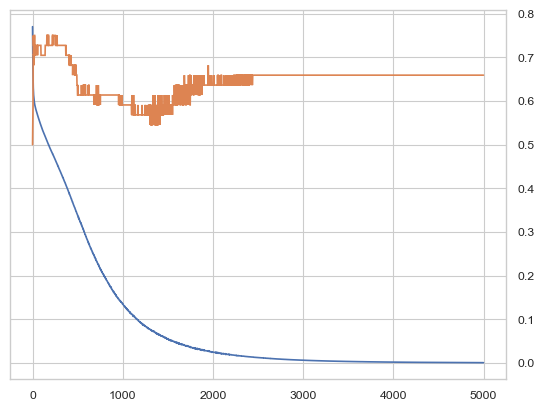

In [70]:
# target Higher
print("TARGET : HIGHER ")
target = df_y["ur_higher"].values
ytrain = target[:nb_test]
ytest = target[nb_test:]
Y = ytrain.reshape(-1, 1)
Y_test = ytest.reshape(-1, 1)

clf = MLPClassifier(random_state=0,
                    hidden_layer_sizes=(32,16),
                    max_iter=5000,
                    early_stopping=True,
                    n_iter_no_change=5000)
clf.fit(X, Y)
print("TRAIN score :", clf.score(X, Y))
print("TEST score :", clf.score(X_test, Y_test))
print("Next month : ", clf.predict(X_for_pred))
print("classes : ", clf.classes_)
print("classes prob : ", clf.predict_proba(X_for_pred))
nb_best = np.argmax( clf.validation_scores_ == clf.best_validation_score_)
print("nb_test: ", nb_best)
plt.plot(clf.loss_curve_)
plt.plot(clf.validation_scores_)


In [71]:
pred = clf.predict(X_for_pred)[0]
arr_prob = clf.predict_proba(X_for_pred)
if pred: 
    prob = arr_prob[0][1]
else:
    prob = arr_prob[0][0]

list_pred.append(pred)
list_prob.append(prob)
print(list_pred, list_prob)

[False, False, False] [0.5972558640980496, 0.5461061258912443, 0.7056783354454876]


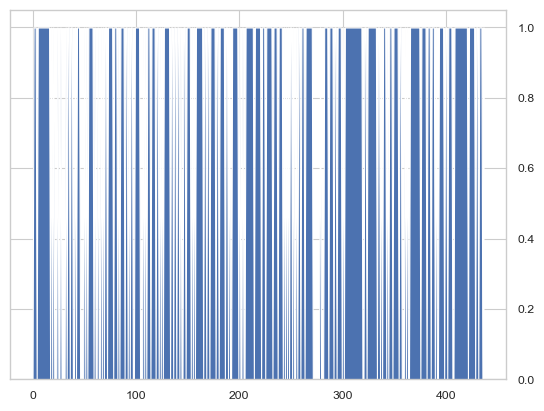

In [72]:
plt.stackplot(range(len(Y)), Y.squeeze() == clf.predict(X))